# Dynamic Parallel Execution with  Map-Reduce using Send in LangGraph


Map-reduce operations are essential for efficient task decomposition and parallel processing.

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

We will design a system that will do two things:

(1) `Map` - Create a set of questions about a topic. Then answer them in parallel (using `Send(...)`)

(2) `Reduce` - Compile a comprehensive report based on the QAs on the topic.

![](https://i.imgur.com/SN7KifO.png)


LangGraph's Map-Reduce pattern enables efficient task decomposition and parallel processing, enhancing performance in complex workflows. The Send function plays a pivotal role in this mechanism.

Map-Reduce in LangGraph:
- Task Decomposition: Breaks down a large task into smaller, manageable sub-tasks (planning or complex question decomposition)
- Parallel Processing: Executes sub-tasks concurrently, significantly reducing overall processing time.
- Result Aggregation: Combines outcomes from all sub-tasks to form a comprehensive response.





## Install OpenAI, LangGraph and LangChain dependencies

In [1]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.1
    Uninstalling langsmith-0.3.1:
      Successfully uninstalled langsmith-0.3.1
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.15
    Uninstalling langchain-0.3.15:
      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.3 MB/s eta 0:00:00


## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Setup Environment Variables

In [3]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Define Agent State Schema

In [4]:
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator
from typing import Annotated

# Define state
class Questions(BaseModel):
    questions: list[str]

class Answer(BaseModel):
    question: str
    answer: str

class Report(BaseModel):
    report: str

class OverallState(TypedDict):
    topic: str
    questions: list
    answers: Annotated[list, operator.add]
    report: str

## Define Agent Node Functions

Role of the Send Function:
- Dynamic Task Distribution: Utilizes the Send function to dispatch different states to multiple instances of a node, facilitating parallel execution.
- Flexible Workflow Management: Very useful when you do not have a fixed number of static edges to parallelize like in router agent. A simple example would be generating a random number of questions or steps to solve a problem and parallelizing the generation process for each of those questions or steps.

In [22]:
from langgraph.constants import Send
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Node to generate questions
def generate_questions(state: OverallState):
    # sometimes gpt-4o just generates 5 questions always so feel free to play around with the following prompt
    # or you can also use gpt-4o-mini or other LLMs or just randomly select a subselt of questions from the response
    # just to demonstrate and see how Send works with a variable number of questions
    questions_prompt = """Generate a list of concise sub-questions related to this overall topic: {topic}
                          which would help build a good report.
                          Follow these rules for question generation:
                            - Do not create very long questions.
                            - Number of questions should always be 3 for simple topics (Birds, Animals, AI)
                              and 5 for more complex topics (Outlook for ..., Impact of ...)
                       """
    prompt = questions_prompt.format(topic=state["topic"])
    response = llm.with_structured_output(Questions).invoke(prompt)
    return {"questions": response.questions}

# Node to generate answer to one question
def generate_answer(state: Answer):
    answer_prompt = """Generate the answer about {question}."""
    prompt = answer_prompt.format(question=state["question"])
    response = llm.with_structured_output(Answer).invoke(prompt)
    return {"answers": [{"question": state["question"], "answer": response.answer}]}

# Node to continue to answers
def continue_to_answers(state: OverallState):
    return [Send("generate_answer", {"question": q}) for q in state["questions"]] # does the parallel execution

# Node to compile the report
def compile_report(state: OverallState):
    q_and_a = "\n\n".join(
        [f"Q: {qa['question']}\nA: {qa['answer']}" for qa in state["answers"]]
    )
    report_prompt = """Below are a bunch of questions and answers about topic:
                       {topic}.
                       Generate a detailed report from this about the topic.
                       {q_and_a}"""
    prompt = report_prompt.format(topic=state["topic"], q_and_a=q_and_a)
    response = llm.with_structured_output(Report).invoke(prompt)
    return {"report": response.report}

## Create Agent

In [23]:
from langgraph.graph import StateGraph, START, END

# Compile the graph
graph = StateGraph(OverallState)
graph.add_node("generate_questions", generate_questions)
graph.add_node("generate_answer", generate_answer)
graph.add_node("compile_report", compile_report)

graph.add_edge(START, "generate_questions")
graph.add_conditional_edges("generate_questions",
                            continue_to_answers,
                            ["generate_answer"])
graph.add_edge("generate_answer", "compile_report")
graph.add_edge("compile_report", END)

# Compile the app
agent = graph.compile()

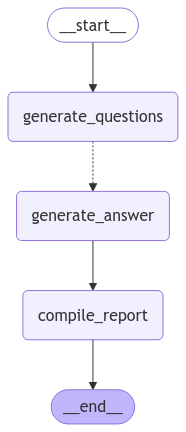

In [24]:
# Display the graph
from IPython.display import display, Image
Image(agent.get_graph().draw_mermaid_png())

## Run and Test the Agent

In [26]:
from IPython.display import display, Markdown

for state in agent.stream({"topic": "Artificial Intelligence"}):
    print(state)
    if 'compile_report' in state:
        display(Markdown(state['compile_report']['report']))

{'generate_questions': {'questions': ['What are the primary types of artificial intelligence?', 'How does machine learning differ from traditional AI?', 'What are the ethical considerations in AI development?']}}
{'generate_answer': {'answers': [{'question': 'What are the ethical considerations in AI development?', 'answer': 'The development and deployment of Artificial Intelligence (AI) technologies bring about numerous ethical considerations that need to be addressed to ensure that these technologies are beneficial, fair, and safe for society. Here are some key ethical considerations in AI development:\n\n1. **Bias and Fairness:**\n   - AI systems can inadvertently perpetuate or even exacerbate existing biases present in the data they are trained on. Ensuring fairness involves actively identifying and mitigating these biases to prevent discrimination against any group based on race, gender, age, or other characteristics.\n\n2. **Transparency and Explainability:**\n   - AI systems, es

## Artificial Intelligence: A Comprehensive Overview

Artificial Intelligence (AI) is a transformative technology that has the potential to revolutionize various aspects of human life. This report delves into the primary types of AI, the differences between traditional AI and machine learning, and the ethical considerations surrounding AI development.

### Types of Artificial Intelligence

AI can be categorized into several types based on their capabilities and functionalities:

1. **Reactive Machines**
   - **Characteristics:** Basic AI systems that respond to immediate inputs without memory or learning capabilities.
   - **Example:** IBM's Deep Blue, a chess-playing computer.

2. **Limited Memory**
   - **Characteristics:** AI systems that use past experiences to inform future decisions.
   - **Example:** Self-driving cars that analyze traffic patterns.

3. **Theory of Mind**
   - **Characteristics:** Theoretical AI that understands human emotions and thoughts.
   - **Example:** Advanced AI personal assistants.

4. **Self-Aware AI**
   - **Characteristics:** Hypothetical AI with consciousness and self-awareness.
   - **Example:** AI systems with human-like cognition.

5. **Artificial Narrow Intelligence (ANI)**
   - **Characteristics:** AI designed for specific tasks, prevalent today.
   - **Example:** Virtual assistants like Siri and Alexa.

6. **Artificial General Intelligence (AGI)**
   - **Characteristics:** AI with human-like problem-solving abilities.
   - **Example:** Hypothetical AI capable of any intellectual task.

7. **Artificial Superintelligence (ASI)**
   - **Characteristics:** AI surpassing human intelligence in all domains.
   - **Example:** Theoretical AI with superior cognitive abilities.

### Traditional AI vs. Machine Learning

**Traditional AI** and **Machine Learning (ML)** are distinct in their approaches:

- **Traditional AI** relies on rule-based systems and symbolic reasoning, requiring manual programming and knowledge engineering. It is deterministic and limited in learning capabilities.

- **Machine Learning** is data-driven, using statistical methods to learn from data and adapt over time. It is flexible, scalable, and capable of continuous learning.

**Applications:**
- Traditional AI: Chess engines, diagnostic systems.
- Machine Learning: Image recognition, recommendation systems.

### Ethical Considerations in AI Development

The ethical implications of AI are vast and multifaceted:

1. **Bias and Fairness:** Ensuring AI systems do not perpetuate discrimination.
2. **Transparency and Explainability:** Making AI decision-making processes understandable.
3. **Privacy and Data Protection:** Safeguarding user data and complying with regulations.
4. **Accountability and Responsibility:** Clarifying who is responsible for AI actions.
5. **Security and Safety:** Protecting AI systems from malicious attacks.
6. **Autonomy and Control:** Balancing machine autonomy with human oversight.
7. **Impact on Employment:** Addressing job displacement due to automation.
8. **Moral and Ethical Decision-Making:** Aligning AI decisions with societal values.
9. **Environmental Impact:** Minimizing the carbon footprint of AI technologies.
10. **Global and Cultural Considerations:** Respecting diverse cultural norms in AI deployment.

### Conclusion

AI is a rapidly evolving field with significant potential to impact society positively. However, it is crucial to address the ethical challenges it presents to ensure that AI technologies are developed responsibly and align with human values. Collaborative efforts from various stakeholders are essential to harness AI's benefits while mitigating its risks.

In [27]:
for state in agent.stream({"topic": "Animals"}):
    print(state)
    if 'compile_report' in state:
        display(Markdown(state['compile_report']['report']))

{'generate_questions': {'questions': ['What are the different classifications of animals?', 'How do animals adapt to their environments?', 'What are the primary threats to animal populations?', 'How do animals communicate with each other?', 'What roles do animals play in ecosystems?']}}
{'generate_answer': {'answers': [{'question': 'What roles do animals play in ecosystems?', 'answer': 'Animals play a multitude of critical roles in ecosystems, contributing to the balance, health, and functionality of their environments. Here are some of the key roles they fulfill:\n\n1. **Pollinators:**\n   - Many animals, such as bees, butterflies, birds, and bats, are essential for pollinating plants. This process is crucial for the reproduction of flowering plants and the production of fruits and seeds.\n\n2. **Seed Dispersers:**\n   - Animals like birds, mammals, and insects help in dispersing seeds by carrying them to new locations, either through ingestion and excretion or by transporting them on

### Detailed Report on Animals

Animals are a diverse group of organisms that play crucial roles in ecosystems, exhibit fascinating adaptations, and face numerous threats. This report delves into the classification, adaptations, threats, communication methods, and ecological roles of animals.

---

### Classification of Animals

Animals are classified using the Linnaean system, which organizes them into hierarchical categories based on shared characteristics and evolutionary history. This system helps scientists understand the diversity of life and evolutionary relationships.

- **Kingdom:** Animalia encompasses all animals.
- **Phylum:** Includes Chordata (vertebrates), Arthropoda (invertebrates with exoskeletons), Mollusca (soft-bodied animals), Annelida (segmented worms), Cnidaria (aquatic animals with stinging cells), and Echinodermata (marine animals with radial symmetry).
- **Class:** Examples include Mammalia (mammals), Aves (birds), Reptilia (reptiles), Amphibia (amphibians), Pisces (fish), and Insecta (insects).
- **Order, Family, Genus, Species:** Further subdivisions categorize animals into more specific groups, such as Carnivora (meat-eating mammals) and Primates (humans, apes, monkeys).

---

### Adaptations of Animals

Animals have evolved a variety of adaptations to survive in their environments. These adaptations can be structural, behavioral, or physiological.

- **Structural Adaptations:** Include camouflage, body shape, and specialized appendages.
- **Behavioral Adaptations:** Include migration, hibernation, and nocturnal activity.
- **Physiological Adaptations:** Include temperature regulation, metabolic adjustments, and venom production.
- **Reproductive and Social Adaptations:** Include parental care, reproductive timing, pack behavior, and communication.

---

### Threats to Animal Populations

Animal populations face numerous threats that can lead to declines and extinction.

- **Habitat Loss and Fragmentation:** Due to deforestation, urbanization, and agricultural expansion.
- **Climate Change:** Affects breeding patterns, migration routes, and food availability.
- **Pollution:** Includes chemical, plastic, air, and water pollution.
- **Overexploitation:** Through hunting, poaching, overfishing, and the pet trade.
- **Invasive Species:** Compete with native species and introduce new diseases.
- **Disease and Human-Wildlife Conflict:** Epidemics and conflicts over land and resources.

---

### Animal Communication

Animals communicate through various methods adapted to their environment and social needs.

- **Vocalizations:** Used by birds, mammals, and insects for mating, territory defense, and social interaction.
- **Body Language:** Used by dogs, primates, and fish to express emotions and intentions.
- **Chemical Signals (Pheromones):** Used by insects and mammals for territory marking and reproductive signaling.
- **Visual Signals:** Used by birds, cephalopods, and fireflies for courtship and camouflage.
- **Tactile Communication:** Used by primates and elephants for social bonding and guidance.
- **Electrical Signals and Vibrations:** Used by electric fish and spiders for navigation and communication.

---

### Roles of Animals in Ecosystems

Animals fulfill critical roles that sustain ecosystems and biodiversity.

- **Pollinators and Seed Dispersers:** Essential for plant reproduction and diversity.
- **Predators and Prey:** Maintain population balance and energy flow in food chains.
- **Decomposers and Scavengers:** Aid in nutrient cycling and soil fertility.
- **Ecosystem Engineers:** Modify environments to create habitats for other species.
- **Herbivores and Nutrient Cyclers:** Influence vegetation structure and enrich soil.
- **Indicators of Ecosystem Health:** Reflect environmental conditions and human impacts.

---

### Conclusion

Animals are integral to the health and functionality of ecosystems. Their diverse adaptations, communication methods, and ecological roles highlight the complexity and resilience of life on Earth. Understanding and addressing the threats they face is crucial for conserving biodiversity and ensuring the sustainability of ecosystems.

In [28]:
for state in agent.stream({"topic": "Impact of AI on jobs"}):
    print(state)
    if 'compile_report' in state:
        display(Markdown(state['compile_report']['report']))

{'generate_questions': {'questions': ['What are the primary industries affected by AI automation?', 'How does AI influence job creation versus job displacement?', 'What skills are becoming more valuable due to AI advancements?', 'How are companies adapting their workforce to integrate AI technologies?', 'What are the potential long-term economic impacts of AI on employment?']}}
{'generate_answer': {'answers': [{'question': 'How are companies adapting their workforce to integrate AI technologies?', 'answer': 'Companies across various industries are increasingly integrating AI technologies to enhance efficiency, innovation, and competitiveness. To successfully adapt their workforce to this technological shift, organizations are employing several strategies:\n\n1. **Upskilling and Reskilling Programs:**\n   - **Training Initiatives:** Companies are investing in training programs to equip employees with the necessary skills to work alongside AI technologies. This includes understanding AI 

## Impact of AI on Jobs: A Comprehensive Analysis

### Introduction
Artificial Intelligence (AI) is a transformative force reshaping industries and the workforce. Its integration into various sectors is driving efficiency, innovation, and economic growth, while also posing challenges related to job displacement and workforce adaptation. This report delves into the primary industries affected by AI, its influence on job creation versus displacement, the skills becoming more valuable, how companies are adapting, and the potential long-term economic impacts on employment.

### Industries Affected by AI Automation
AI automation is revolutionizing numerous sectors by enhancing efficiency, reducing costs, and enabling new capabilities. Key industries impacted include:

1. **Manufacturing**: AI-driven robotics and predictive maintenance are streamlining production processes.
2. **Healthcare**: AI assists in diagnostics, personalized medicine, and administrative tasks.
3. **Finance**: Algorithmic trading, fraud detection, and AI-powered customer service are transforming financial services.
4. **Retail**: AI optimizes inventory management, personalized marketing, and customer experience.
5. **Transportation and Logistics**: Autonomous vehicles and route optimization are enhancing logistics.
6. **Agriculture**: Precision farming and crop monitoring are improving agricultural efficiency.
7. **Energy**: AI optimizes smart grids and predictive maintenance in energy sectors.
8. **Telecommunications**: Network optimization and automated customer support are key AI applications.
9. **Education**: Personalized learning and administrative automation are reshaping education.
10. **Real Estate**: AI is transforming property management and market analysis.

### AI's Influence on Job Creation vs. Job Displacement
AI's impact on employment is multifaceted, with both positive and negative implications:

- **Job Creation**: AI is creating new industries and roles, increasing productivity, and driving economic growth. Skills development and educational programs are expanding to meet the demand for AI-related expertise.
- **Job Displacement**: Automation of routine tasks and sector-specific impacts are leading to job displacement, particularly in manufacturing, transportation, and retail. Skill mismatches pose challenges for displaced workers.

### Skills Becoming More Valuable
As AI evolves, certain skills are gaining prominence:

- **Data Literacy**: Understanding data collection and analysis is crucial.
- **Machine Learning and AI Development**: Skills in AI algorithms and programming are in high demand.
- **Critical Thinking and Problem Solving**: Human oversight is needed to interpret AI outputs.
- **Ethical AI Use**: Understanding AI's ethical implications is essential.
- **Interdisciplinary Knowledge**: Combining knowledge from various fields enhances AI applications.
- **Communication and Collaboration**: Explaining AI concepts and working in diverse teams is vital.
- **Adaptability and Continuous Learning**: Staying updated with AI advancements is crucial.
- **Cybersecurity Skills**: Protecting AI systems from threats is increasingly important.
- **User Experience Design**: Ensuring AI applications are user-friendly is key.
- **Project Management**: Managing AI projects requires unique skills.

### How Companies Are Adapting
Organizations are employing several strategies to integrate AI technologies:

- **Upskilling and Reskilling Programs**: Training initiatives and online courses are equipping employees with AI skills.
- **Creating AI-Centric Roles**: New job titles and cross-functional teams are emerging.
- **Cultural Shift and Change Management**: Promoting a growth mindset and transparent communication are essential.
- **Collaborative Human-AI Workflows**: AI augments human capabilities, enhancing decision-making.
- **Ethical and Responsible AI Use**: Ethics training and AI governance frameworks are being established.
- **Investing in AI Infrastructure**: Upgrading technology and partnering with AI vendors are common practices.
- **Pilot Projects and Experimentation**: Testing AI technologies in specific areas allows for learning and adjustment.

### Potential Long-Term Economic Impacts
AI's integration into various sectors has profound long-term economic impacts on employment:

- **Job Displacement and Transformation**: Automation leads to job displacement, but many roles will evolve.
- **Creation of New Job Opportunities**: New industries and increased demand for tech skills will emerge.
- **Impact on Wages and Income Inequality**: Wage polarization and income inequality may increase.
- **Changes in Workforce Dynamics**: The gig economy and remote work will expand.
- **Need for Reskilling and Education**: Lifelong learning and educational reforms are essential.
- **Policy and Regulatory Considerations**: Labor market policies and ethical frameworks are crucial.

### Conclusion
AI's impact on jobs is complex and context-dependent. While it offers opportunities for innovation and economic growth, it also presents challenges that require proactive management. Balancing technological advancement with social equity will be key to harnessing AI's potential for a prosperous future.